# Chlorophyll

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client

import catalog
import util

xr.set_options(keep_attrs=True)

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [21]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from glob import glob

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT

### Parameters

In [5]:
casename = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'
component = 'pop'
stream = 'h'

cluster_scheduler_address = None

In [6]:
assert component in ['pop']
assert stream in ['h', 'h.ecosys.nday1']

### Connect to cluster

In [7]:
if cluster_scheduler_address is None:
    cluster, client = util.get_ClusterClient()
    cluster.scale(12)
else:
    client = Client(cluster_scheduler_address)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.26:44430,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load the data

In [8]:
dsets = catalog.to_dataset_dict(
    case=casename,
    component=component,
    stream=stream,
)
dsets.keys()

dict_keys(['g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1.pop.h'])

## Compute long-term mean and plot

In [9]:
ds = dsets[f'{casename}.{component}.{stream}']

### Variable list

In [10]:
variables =['diatChl', 'coccoChl','spChl','diazChl']

In [11]:
keep_vars=['z_t','z_t_150m','dz','time_bound','TAREA','TLAT','TLONG'] + variables
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

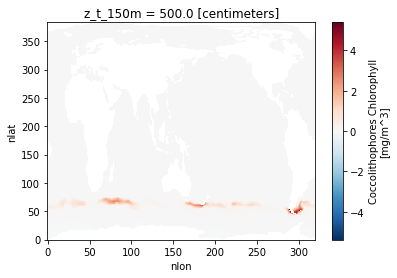

In [12]:
ds.coccoChl.isel(time=0,z_t_150m=0).plot()

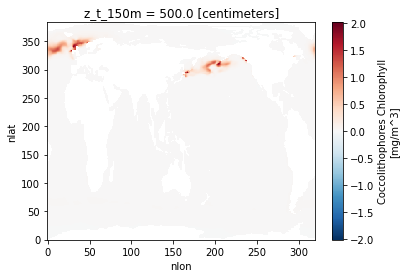

In [13]:
ds.coccoChl.isel(time=6,z_t_150m=0).plot()

In [14]:
ds = ds.isel(z_t_150m=0)

In [15]:
ds['Chl_surf'] = ds.spChl + ds.diatChl + ds.coccoChl + ds.diazChl

In [16]:
dt_wgt = ds.time_bound.diff('d2').squeeze()
dt_wgt /= dt_wgt.sum()
dt_wgt

<xarray.DataArray 'time_bound' (time: 120)>
dask.array<truediv, shape=(120,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    z_t_150m  float32 500.0
Dimensions without coordinates: time
Attributes:
    long_name:  boundaries for time-averaging interval
    units:      days since 0000-01-01 00:00:00

In [17]:
ds = ds.weighted(dt_wgt).mean('time')

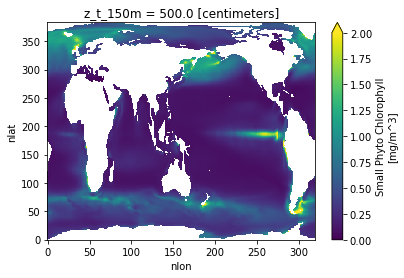

In [19]:
ds['Chl_surf'].plot(vmin=0,vmax=2)

### Grab Globcolour observations of Chlorophyll

In [22]:
path = '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_'
files = []
files.extend(sorted(glob(f'{path}*.nc')))
ds_sat=xr.open_mfdataset(files,concat_dim='time',combine='nested')

In [24]:
ds_sat = ds_sat.mean(dim='time')

### Plot maps comparisons (first on linear scale, then on log scale)

In [33]:
cpt = 'Greens'

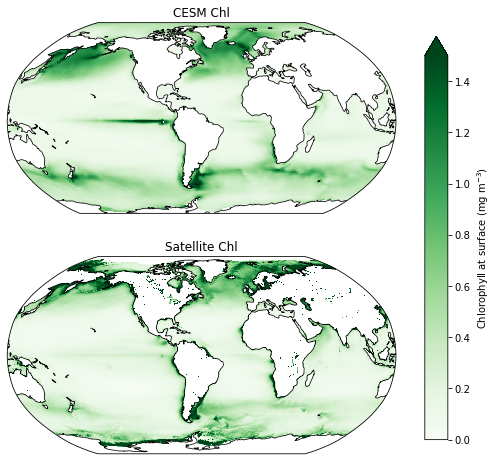

In [38]:
###### 
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.Chl_surf)
ax.coastlines('110m',linewidth=0.75)
pc=ax.pcolormesh(lon, lat, field, cmap=cpt,vmin=0,vmax=1.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Satellite Chl', fontsize=12)
pc=ax.pcolormesh(ds_sat.lon, ds_sat.lat, ds_sat.CHL1_mean, cmap=cpt,vmin=0,vmax=1.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.04, 0.7])
#cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='Chlorophyll at surface (mg m$^{-3}$)');


In [30]:
import matplotlib.colors as colors

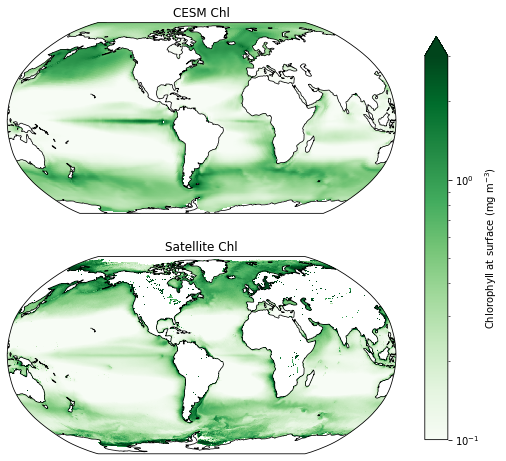

In [37]:
###### 
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.Chl_surf)
ax.coastlines('110m',linewidth=0.75)
pc=ax.pcolormesh(lon, lat, field, cmap=cpt,norm=colors.LogNorm(vmin=0.1, vmax=3),transform=ccrs.PlateCarree())

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Satellite Chl', fontsize=12)
pc=ax.pcolormesh(ds_sat.lon, ds_sat.lat, ds_sat.CHL1_mean, cmap=cpt,norm=colors.LogNorm(vmin=0.1, vmax=3),transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.04, 0.7])
#cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='Chlorophyll at surface (mg m$^{-3}$)');